In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [2]:
df_aaindex = pd.read_csv('data/aaindex/df_aaindex19.csv')
print(df_aaindex.shape)
df_aaindex.head(1)
tmp = df_aaindex.drop('Unnamed: 0',axis=1).T
aa2val = dict()
for aa, val in zip(tmp.index, tmp.values):
    aa2val[aa]=val

(19, 21)


In [3]:
df_detect_peptide_train = pd.read_csv('data/df_detect_peptide_train.csv')
test = pd.read_csv('data/df_detect_peptide_test.csv')
train, val = train_test_split(df_detect_peptide_train, test_size=0.2, random_state=7)

In [4]:
train.head(1)

,peptide,En,Ec,E1,E2,protein,PEP,ID
210101,R.MDKVHSEAER.L,QQKVLQQRMDKVHSE,KVHSEAERLEARFQD,VLQQRMDKVHSEAER,-,sp|Q96M63|CC114_HUMAN,MDKVHSEAER,0


In [5]:
def get_data(df):
    aa_data = [np.array([seq.count(a) for a in 'ARNDCQEGHILKMFPSTWYVZ'] + list(np.array([aa2val[aa] for aa in seq]).sum(axis=0)))
               for seq in df.PEP.values]
    pep_data = [[[1 if aa == a else 0 for a in 'ARNDCQEGHILKMFPSTWYVZ'] for aa in seq] + [[0]*21]*(30-len(seq))
               for seq in df.PEP.values]
    en_data = [[[1 if aa == a else 0 for a in 'ARNDCQEGHILKMFPSTWYVZ'] for aa in seq]
               for seq in df.En.values]
    ec_data = [[[1 if aa == a else 0 for a in 'ARNDCQEGHILKMFPSTWYVZ'] for aa in seq]
               for seq in df.Ec.values]
    e1_data = [[[1 if aa == a else 0 for a in 'ARNDCQEGHILKMFPSTWYVZ'] for aa in seq]
               if seq != '-' else [[0]*21 for _ in range(15)]
               for seq in df.E1.values]
    e2_data = [[[1 if aa == a else 0 for a in 'ARNDCQEGHILKMFPSTWYVZ'] for aa in seq]
               if seq != '-' else [[0]*21 for _ in range(15)]
               for seq in df.E2.values]
    return np.array(aa_data), np.array(pep_data), np.array(en_data), np.array(ec_data), np.array(e1_data), np.array(e2_data), np.array(df.ID.values)

In [6]:
aa_train, pep_train, en_train, ec_train, e1_train, e2_train, y_train = get_data(train)

aa_val, pep_val, en_val, ec_val, e1_val, e2_val, y_val = get_data(val)

aa_test, pep_test, en_test, ec_test, e1_test, e2_test, y_test = get_data(test)

print(aa_train.shape, pep_train.shape, en_train.shape, ec_train.shape, e1_train.shape, e2_train.shape, y_train.shape)

print(aa_val.shape, pep_val.shape, en_val.shape, ec_val.shape, e1_val.shape, e2_val.shape, y_val.shape)

print(aa_test.shape, pep_test.shape, en_test.shape, ec_test.shape, e1_test.shape, e2_test.shape, y_test.shape)

(215352, 40) (215352, 30, 21) (215352, 15, 21) (215352, 15, 21) (215352, 15, 21) (215352, 15, 21) (215352,)
(53838, 40) (53838, 30, 21) (53838, 15, 21) (53838, 15, 21) (53838, 15, 21) (53838, 15, 21) (53838,)
(67298, 40) (67298, 30, 21) (67298, 15, 21) (67298, 15, 21) (67298, 15, 21) (67298, 15, 21) (67298,)


# Train

In [7]:
from tensorflow.python.client import device_lib

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[1],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*4)])
    except RuntimeError as e:
        print(e)

In [9]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

# high param

In [14]:
input1 = tf.keras.layers.Input(shape=((30,21,)))  # peptide with zero padding
input2 = tf.keras.layers.Input(shape=((40,)))  # peptide info
input3 = tf.keras.layers.Input(shape=((15,21,)))  # N term info
input4 = tf.keras.layers.Input(shape=((15,21,)))  # C term info
input5 = tf.keras.layers.Input(shape=((15,21,)))  # miss1 term info
input6 = tf.keras.layers.Input(shape=((15,21,)))  # miss2 term info


lstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16))(input1)
net_lstm_ = tf.keras.layers.Dense(32, activation='relu')(lstm1)
net_lstm = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(net_lstm_)

net_dense1 = tf.keras.layers.Dense(32, activation='relu')(input2)

digest_n = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16))(input3)
net_n_ = tf.keras.layers.Dense(32, activation='relu')(digest_n)
net_n = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(net_n_)

digest_c = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16))(input4)
net_c_ = tf.keras.layers.Dense(32, activation='relu')(digest_c)
net_c = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(net_c_)

digest_m1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16))(input5)
net_m1_ = tf.keras.layers.Dense(32, activation='relu')(digest_m1)
net_m1 = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(net_m1_)

digest_m2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16))(input6)
net_m2_ = tf.keras.layers.Dense(32, activation='relu')(digest_m2)
net_m2 = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(net_m2_)

merge = tf.keras.layers.concatenate([net_lstm, 
                                     net_dense1,
                                     net_n,
                                     net_c,
                                     net_m1,
                                     net_m2])

net1 = tf.keras.layers.Dense(128, activation='relu')(merge)
net1_drop = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(net1)

net2 = tf.keras.layers.Dense(64, activation='relu')(net1_drop)
net2_drop = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(net2)

output = tf.keras.layers.Dense(1, activation = 'sigmoid')(net2_drop)

model_high = tf.keras.Model(inputs=[input1, input2,
                              input3, input4,
                              input5, input6],
                       outputs=[output])

model_high.summary()

model_high.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                      mode='min', 
                                      verbose=1,
                                      patience=20)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 30, 21)]     0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 15, 21)]     0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 15, 21)]     0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 15, 21)]     0                                            
____________________________________________________________________________________________

In [15]:
history = model_high.fit([pep_train, aa_train, en_train, ec_train, e1_train, e2_train],
                    y_train, 
                    epochs=300,
                    batch_size=64,
                    validation_data=([pep_val, aa_val, en_val, ec_val, e1_val, e2_val], y_val),
                    callbacks=[es])

Epoch 1/300
3365/3365 [==============================] - 169s 47ms/step - loss: 4.8917 - accuracy: 0.5683 - val_loss: 0.5169 - val_accuracy: 0.7417
Epoch 2/300
3365/3365 [==============================] - 153s 45ms/step - loss: 0.5354 - accuracy: 0.7360 - val_loss: 0.4841 - val_accuracy: 0.7712
Epoch 3/300
3365/3365 [==============================] - 153s 46ms/step - loss: 0.4950 - accuracy: 0.7634 - val_loss: 0.4635 - val_accuracy: 0.7806
Epoch 4/300
3365/3365 [==============================] - 152s 45ms/step - loss: 0.4780 - accuracy: 0.7724 - val_loss: 0.4588 - val_accuracy: 0.7823
Epoch 5/300
3365/3365 [==============================] - 153s 46ms/step - loss: 0.4654 - accuracy: 0.7788 - val_loss: 0.4524 - val_accuracy: 0.7852
Epoch 6/300
3365/3365 [==============================] - 152s 45ms/step - loss: 0.4595 - accuracy: 0.7858 - val_loss: 0.4444 - val_accuracy: 0.7899
Epoch 7/300
3365/3365 [==============================] - 154s 46ms/step - loss: 0.4505 - accuracy: 0.7900 - val_

3365/3365 [==============================] - 153s 45ms/step - loss: 0.3765 - accuracy: 0.8312 - val_loss: 0.3831 - val_accuracy: 0.8287
Epoch 57/300
3365/3365 [==============================] - 152s 45ms/step - loss: 0.3751 - accuracy: 0.8332 - val_loss: 0.3810 - val_accuracy: 0.8298
Epoch 58/300
3365/3365 [==============================] - 152s 45ms/step - loss: 0.3758 - accuracy: 0.8327 - val_loss: 0.3822 - val_accuracy: 0.8298
Epoch 59/300
3365/3365 [==============================] - 151s 45ms/step - loss: 0.3745 - accuracy: 0.8334 - val_loss: 0.3809 - val_accuracy: 0.8302
Epoch 60/300
3365/3365 [==============================] - 154s 46ms/step - loss: 0.3748 - accuracy: 0.8322 - val_loss: 0.3814 - val_accuracy: 0.8308
Epoch 61/300
3365/3365 [==============================] - 153s 45ms/step - loss: 0.3758 - accuracy: 0.8327 - val_loss: 0.3815 - val_accuracy: 0.8297
Epoch 62/300
3365/3365 [==============================] - 153s 45ms/step - loss: 0.3750 - accuracy: 0.8329 - val_loss: 

Epoch 111/300
3365/3365 [==============================] - 151s 45ms/step - loss: 0.3570 - accuracy: 0.8424 - val_loss: 0.3739 - val_accuracy: 0.8337
Epoch 112/300
3365/3365 [==============================] - 153s 45ms/step - loss: 0.3575 - accuracy: 0.8415 - val_loss: 0.3733 - val_accuracy: 0.8344
Epoch 113/300
3365/3365 [==============================] - 152s 45ms/step - loss: 0.3562 - accuracy: 0.8420 - val_loss: 0.3749 - val_accuracy: 0.8343
Epoch 114/300
3365/3365 [==============================] - 152s 45ms/step - loss: 0.3565 - accuracy: 0.8428 - val_loss: 0.3740 - val_accuracy: 0.8351
Epoch 115/300
3365/3365 [==============================] - 151s 45ms/step - loss: 0.3579 - accuracy: 0.8421 - val_loss: 0.3732 - val_accuracy: 0.8350
Epoch 116/300
3365/3365 [==============================] - 152s 45ms/step - loss: 0.3567 - accuracy: 0.8416 - val_loss: 0.3725 - val_accuracy: 0.8341
Epoch 117/300
3365/3365 [==============================] - 153s 45ms/step - loss: 0.3562 - accuracy:

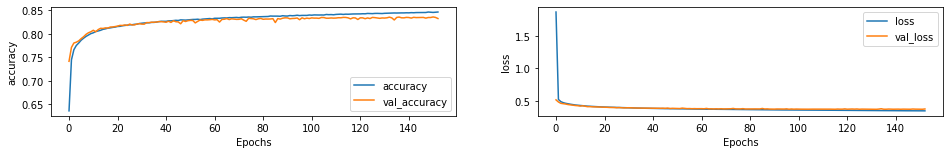

In [16]:
plt.figure(figsize=(16,2))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.subplot(1,2,2)
plot_graphs(history, 'loss')

# eval

2104/2104 [==============================] - 37s 18ms/step - loss: 0.3752 - accuracy: 0.8330
Test Loss: 0.37522298097610474
Test Accuracy: 0.8330410718917847
              precision    recall  f1-score   support

           0       0.85      0.80      0.83     33706
           1       0.81      0.86      0.84     33592

    accuracy                           0.83     67298
   macro avg       0.83      0.83      0.83     67298
weighted avg       0.83      0.83      0.83     67298

rf auc : 0.9142549718474673


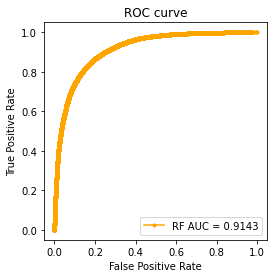

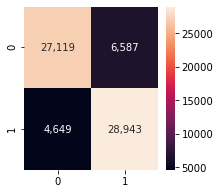

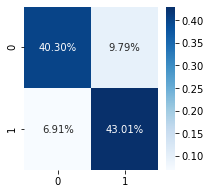

In [17]:
test_loss, test_acc = model_high.evaluate([pep_test, aa_test, en_test, ec_test, e1_test, e2_test], y_test)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

# prediction
y_pred = [1 if i>=0.5 else 0 for i in model_high.predict([pep_test, aa_test, en_test, ec_test, e1_test, e2_test])]
print(classification_report(y_test, y_pred))
# AUC
probs = model_high.predict([pep_test, aa_test, en_test, ec_test, e1_test, e2_test])
rf_auc = roc_auc_score(y_test, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model_high
rf_fpr, rf_tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()